In [1]:
import json
import requests
import pandas as pd
import numpy as np
from itertools import chain
from matplotlib import pyplot as plt
import matplotlib.lines as mlines

In [2]:
user = "marina"
pw = "testingfuji"
sparql_endpoint = "https://orkg.org/triplestore"
fuji_server = "http://localhost:1071/fuji/api/v1/evaluate"

In [3]:
def get_assessment(load):
    global count
    print(count)
    print(load)
    payload = {
        "metadata_service_endpoint": sparql_endpoint,
        "metadata_service_type": "sparql",
        "object_identifier": load,
        "test_debug": True,
        "use_datacite": True
    }
    response = requests.post(
        url = fuji_server,
        json = payload,
        auth = (user, pw)
    )
    summary = response.json().get("summary")
    count = count + 1
    print("__________________________")
    return summary

In [4]:
def split_summary(df):
    df["maturity"] = df["assessment_summary"].map(lambda x: x.get("maturity"))
    df["score_earned"] = df["assessment_summary"].map(lambda x: x.get("score_earned"))
    df["score_percent"] = df["assessment_summary"].map(lambda x: x.get("score_percent"))
    df["score_total"] = df["assessment_summary"].map(lambda x: x.get("score_total"))
    df["status_passed"] = df["assessment_summary"].map(lambda x: x.get("status_passed"))
    df["status_total"] = df["assessment_summary"].map(lambda x: x.get("status_total"))
    df = df.drop(["assessment_summary"], axis=1)
    return df


Metric descriptions as stated on https://www.f-uji.net/index.php:

Findable:
- FsF-F1-01D - Data is assigned a globally unique identifier.
    - FsF-F1-01D-1: Identifier is resolvable and follows a defined unique identifier syntax (IRI, URL)
    - FsF-F1-01D-2: Identifier is not resolvable but follows an UUID or HASH type syntax
- FsF-F1-02D - Data is assigned a persistent identifier
    - FsF-F1-02D-1: Identifier follows a defined persistent identifier syntax
    - FsF-F1-02D-2: Persistent identifier is resolvable
- FsF-F2-01M: Metadata includes descriptive core elements (creator, title, data identifier, publisher, publication date, summary and keywords) to support data findability.
    - FsF-F2-01M-1: Metadata has been made available via common web methods
    - a: Metadata is embedded in the landing page XHTML/HTML code
    - b: Metadata is accessible through content negotiation
    - c: Metadata is accessible via typed links
    - d: Metadata is accessible via signposting links
    - FsF-F2-01M-2: Core data citation metadata is available
    - FsF-F2-01M-3: Core descriptive metadata is available
- FsF-F3-01M: Metadata includes the identifier of the data it describes.
    - FsF-F3-01M-1: Metadata contains data content related information (file name, size, type)
    - FsF-F3-01M-2: Metadata contains a PID or URL which indicates the location of the downloadable data content
- FsF-F4-01M: Metadata is offered in such a way that it can be retrieved programmatically
    - FsF-F4-01M-1: Metadata is given in a way major search engines can ingest it for their catalogues (JSON-LD, Dublin Core, RDFa)
    - FsF-F4-01M-2: Metadata is registered in major research data registries (DataCite)

Accessible:
- FsF-A1-01M: Metadata contains access level and access conditions of the data
    - FsF-A1-01M-1: Information about access restrictions or rights can be identified in metadata
    - FsF-A1-01M-2: Data access information is machine readable
    - FsF-A1-01M-3: Data access information is indicated by (not machine readable) standard terms
- FsF-A1-03D: Data is accessible through a standardized communication protocol
    - FsF-A1-03D-1: Metadata includes a resolvable link to data based on standardized web communication protocols
- FsF-A1-02M: Metadata is accessible through a standardized communication protocol
    - FsF-A1-02M-1: Landing page link is based on standardized web communication protocols.

Interoperable:
- FsF-I1-01M: Metadata is represented using a formal knowledge representation language
    - FsF-I1-01M-1: Parsable, structured metadata (JSON-LD, RDFa) is embedded in the landing page XHTML/HTML code
    - FsF-I1-01M-2: Parsable, graph data (RDF, JSON-LD) is accessible through content negotiation, typed links or sparql endpoint
- FsF-I2_01M: Metadata uses semantic resources
    - FsF-I2-01M-1: Vocabulary namespace URIs can be identified in metadata
    - FsF-I2-01M-2: Namespaces of known semantic resources can be identified in metadata
- FsF-I3-01M: Metadata includes links between the data and its related entities
    - FsF-I3-01M-1: Related resources are explicitly mentioned in metadata
    - FsF-I3-01M-2: Related resources are indicated by machine readable links or identifiers

Reusable:
- FsF-R1-01M: Metadata specifies the content of the data
    - FsF-R1-01MD-1: Minimal information about available data content is given in metadata
    - a: Resource type (e.g. dataset) is given in metadata
    - b: Information about data content (e.g. links) is given in metadata
    - FsF-R1-01MD-2: Verifiable data descriptors (file info, measured variables or observation types) are specified in metadata
    - a: File size and type information are specified in metadata
    - b: Measured variables or observation types are specified in metadata
    - FsF-R1-01MD-3: Data content matches file type and size specified in metadata
    - FsF-R1-01MD-4: Data content matches measured variables or observation types specified in metadata
- FsF-R1.1-01M: Metadata includes license information under which data can be reused
    - FsF-R1.1-01M-1: Licence information is given in an appropriate metadata element
    - FsF-R1.1-01M-2: Recognized licence is valid and registered at SPDX
- FsF-R1.2-01M: Metadata includes provenance information about data creation or generation
    - FsF-R1.2-01M-1: Metadata contains elements which hold provenance information and can be mapped to PROV
    - FsF-R1.2-01M-2: Metadata contains provenance information using formal provenance ontologies (PROV-O)
- FsF-R1.3-01M: Metadata follows a standard recommended by the target research community of the data
    - FsF-R1.3-01M-1: Community specific metadata standard is detected using namespaces or schemas found in provided metadata or metadata services outputs
    - FsF-R1.3-01M-2: Community specific metadata standard is listed in the re3data record of the responsible repository
    - FsF-R1.3-01M-3: Multidisciplinary but community endorsed metadata (RDA Metadata Standards Catalog) standard is listed in the re3data record or detected by namespace
- FsF-R1.3-02D: Data is available in a file format recommended by the target research community
    - FsF-R1.3-02D-1: The format of a data file given in the metadata is listed in the long term file formats, open file formats or scientific file formats controlled list
    - a: The format of the data file is an open format
    - b: The format of the data file is a long term format
    - c: The format of the data file is a scientific format

# Papers

In [5]:
def extend_paper_df(df):
    df_ext = pd.DataFrame()

    df_ext['paper'] = list(chain.from_iterable([[x]*17 for x in df['paper']]))
    try:
        df_ext['doi'] = list(chain.from_iterable([[x]*17 for x in df['doi']]))
    except KeyError:
        pass
    df_ext['research_field_label'] = list(chain.from_iterable([[x]*17 for x in df['research_field_label']]))
    df_ext['metric'] = list(chain.from_iterable(list(x.keys()) for x in df['maturity']))
    df_ext['maturity'] = list(chain.from_iterable(x.values() for x in df['maturity']))
    df_ext['score_earned'] = list(chain.from_iterable(x.values() for x in df['score_earned']))
    df_ext['score_percent'] = list(chain.from_iterable(x.values() for x in df['score_percent']))
    df_ext['score_total'] = list(chain.from_iterable(x.values() for x in df['score_total']))
    df_ext['status_passed'] = list(chain.from_iterable(x.values() for x in df['status_passed']))
    df_ext['status_total'] = list(chain.from_iterable(x.values() for x in df['status_total']))

    return df_ext

## Paper evaluation via DOI

### Paper assessment via DOI

In [6]:
%%script false --no-raise-error
paper_doi_df = pd.read_csv("raw_data/orkg_papers_2023-03-29.csv", index_col=0)
count = 0
paper_doi_df["assessment_summary"] = paper_doi_df["doi"].map(lambda x: get_assessment("https://doi.org/" + x))
paper_doi_df = paper_doi_df[paper_doi_df["assessment_summary"].isna() == False].reset_index(drop=True)
paper_doi_df_split = split_summary(paper_doi_df)
paper_doi_df_assessed = extend_paper_df(paper_doi_df_split)
paper_doi_df_assessed.to_csv("assessed_data/paper_doi_df_F-UJI_assessment.csv")
paper_doi_df_assessed

Couldn't find program: 'false'


### Paper evaluation via DOI + visualizations

In [7]:
paper_doi_df_assessed = pd.read_csv("assessed_data/paper_doi_df_F-UJI_assessment.csv", index_col=0)
paper_doi_df_assessed

,paper,doi,research_field_label,metric,maturity,score_earned,score_percent,score_total,status_passed,status_total
0,http://orkg.org/orkg/resource/R1004,10.1186/s12866-016-0676-9,Bioinformatics,A,2.0,2.0,66.67,3.0,2,3
1,http://orkg.org/orkg/resource/R1004,10.1186/s12866-016-0676-9,Bioinformatics,A1,2.0,2.0,66.67,3.0,2,3
2,http://orkg.org/orkg/resource/R1004,10.1186/s12866-016-0676-9,Bioinformatics,F,2.0,5.0,71.43,7.0,4,5
3,http://orkg.org/orkg/resource/R1004,10.1186/s12866-016-0676-9,Bioinformatics,F1,3.0,2.0,100.00,2.0,2,2
4,http://orkg.org/orkg/resource/R1004,10.1186/s12866-016-0676-9,Bioinformatics,F2,3.0,2.0,100.00,2.0,1,1
...,...,...,...,...,...,...,...,...,...,...
83822,http://orkg.org/orkg/resource/R9639,10.1007/978-3-030-30760-8_18,Computer Sciences,R,1.0,2.0,20.00,10.0,2,5
83823,http://orkg.org/orkg/resource/R9639,10.1007/978-3-030-30760-8_18,Computer Sciences,R1,1.0,1.0,25.00,4.0,0,1
83824,http://orkg.org/orkg/resource/R9639,10.1007/978-3-030-30760-8_18,Computer Sciences,R1.1,0.0,0.0,0.00,2.0,0,1
83825,http://orkg.org/orkg/resource/R9639,10.1007/978-3-030-30760-8_18,Computer Sciences,R1.2,2.0,1.0,50.00,2.0,1,1


In [8]:
paper_doi_df_FAIR = paper_doi_df_assessed[paper_doi_df_assessed["metric"] == "FAIR"].reset_index(drop=True)
paper_doi_df_FAIR

,paper,doi,research_field_label,metric,maturity,score_earned,score_percent,score_total,status_passed,status_total
0,http://orkg.org/orkg/resource/R1004,10.1186/s12866-016-0676-9,Bioinformatics,FAIR,2.00,15.0,62.50,24.0,12,16
1,http://orkg.org/orkg/resource/R107618,10.1007/s11423-020-09885-z,Learner-Interface Interaction,FAIR,2.00,13.0,54.17,24.0,11,16
2,http://orkg.org/orkg/resource/R107663,10.1111/1467-8535.00213,Learner-Interface Interaction,FAIR,1.00,4.0,16.67,24.0,5,16
3,http://orkg.org/orkg/resource/R107834,10.32870/Ap.v12n2.1910,Learner-Interface Interaction,FAIR,1.75,9.0,37.50,24.0,11,16
4,http://orkg.org/orkg/resource/R107843,10.19173/irrodl.v4i2.149,Learner-Interface Interaction,FAIR,1.25,6.0,25.00,24.0,7,16
...,...,...,...,...,...,...,...,...,...,...
4926,http://orkg.org/orkg/resource/R8441,10.1016/j.jbiotec.2013.12.009,Systems Biology,FAIR,1.50,7.5,31.25,24.0,9,16
4927,http://orkg.org/orkg/resource/R9154,10.1073/pnas.1913007117,Life Sciences,FAIR,1.25,6.0,25.00,24.0,7,16
4928,http://orkg.org/orkg/resource/R9190,10.1007/978-3-319-54064-1_3,Biotechnology,FAIR,1.75,12.0,50.00,24.0,10,16
4929,http://orkg.org/orkg/resource/R9295,10.1038/nprot.2016.182,Biotechnology,FAIR,1.75,12.5,52.08,24.0,11,16


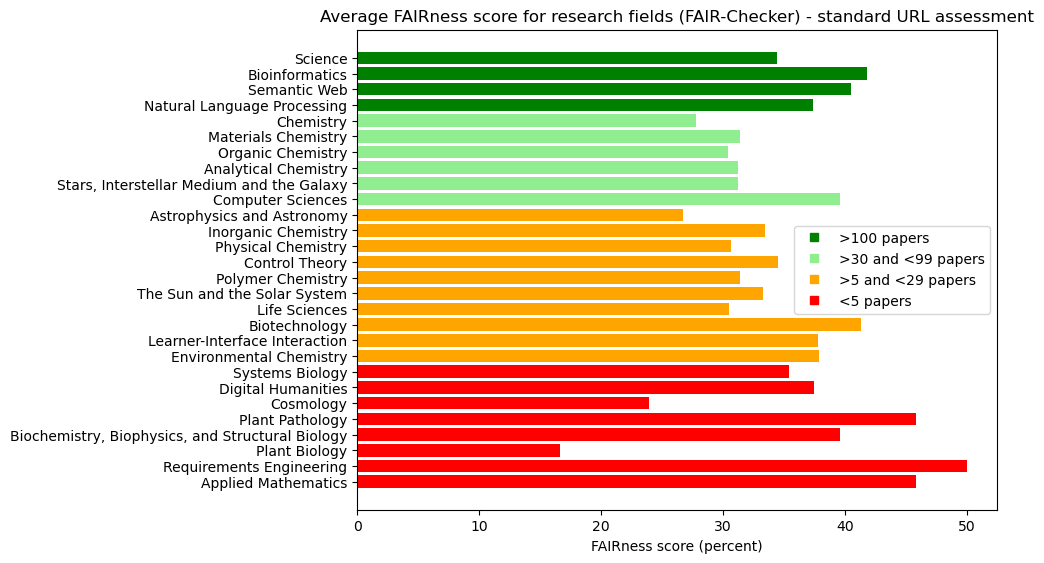

In [9]:
agg_funcs = {'score_earned': 'mean', 'score_percent': 'mean', 'score_total': 'mean', 'status_passed': 'mean', 'status_total': 'mean'}
paper_doi_df_FAIR_fields = paper_doi_df_FAIR.groupby("research_field_label").agg(agg_funcs)
paper_doi_df_FAIR_fields["counts"] = paper_doi_df_FAIR["research_field_label"].value_counts()
paper_doi_df_FAIR_fields = paper_doi_df_FAIR_fields.sort_values("counts")
paper_doi_df_FAIR_fields = paper_doi_df_FAIR_fields.reset_index()

plot = plt.figure()
ax = plot.add_axes([0,0,1,1])
fields = paper_doi_df_FAIR_fields['research_field_label']
avg_scores = paper_doi_df_FAIR_fields['score_percent']
counts_color = [{p<5: 'red', 5<=p<30: 'orange', 30<=p<=100: 'lightgreen', p>100: 'green'}[True] for p in paper_doi_df_FAIR_fields["counts"]]
ax.barh(fields, avg_scores, color=counts_color)
leg_red = mlines.Line2D([], [], color="red", marker="s", ls='', label="<5 papers")
leg_orange = mlines.Line2D([], [], color="orange", marker="s", ls='', label=">5 and <29 papers")
leg_lightgreen = mlines.Line2D([], [], color="lightgreen", marker="s", ls='', label=">30 and <99 papers")
leg_green = mlines.Line2D([], [], color="green", marker="s", ls='', label=">100 papers")
plt.legend(handles=[leg_green, leg_lightgreen, leg_orange, leg_red])
plt.title("Average FAIRness score for research fields (FAIR-Checker) - standard URL assessment")
plt.xlabel("FAIRness score (percent)")
plt.show()

In [10]:
paper_doi_F_A_I_R = paper_doi_df_assessed[(paper_doi_df_assessed['metric'] == "F") | (paper_doi_df_assessed['metric'] == "A") | (paper_doi_df_assessed['metric'] == "I") | (paper_doi_df_assessed['metric'] == "R")].reset_index(drop=True)

agg_funcs = {'maturity': 'mean', 'score_earned': 'mean', 'score_percent': 'mean', 'score_total': 'mean', 'status_passed': 'mean', 'status_total': 'mean'}
paper_doi_F_A_I_R = paper_doi_F_A_I_R.groupby("metric", as_index=False).agg(agg_funcs)

paper_doi_F_A_I_R['metric'] = pd.Categorical(paper_doi_F_A_I_R['metric'], ["F", "A", "I", "R"])
paper_doi_F_A_I_R = paper_doi_F_A_I_R.sort_values('metric').reset_index(drop=True)

paper_doi_F_A_I_R

,metric,maturity,score_earned,score_percent,score_total,status_passed,status_total
0,F,1.673900,3.621983,51.741004,7.0,3.539242,5.0
1,A,0.926384,0.969276,32.306743,3.0,1.012168,3.0
2,I,2.575948,3.108903,77.722571,4.0,2.575948,3.0
3,R,1.000000,1.066518,10.665179,10.0,1.815048,5.0


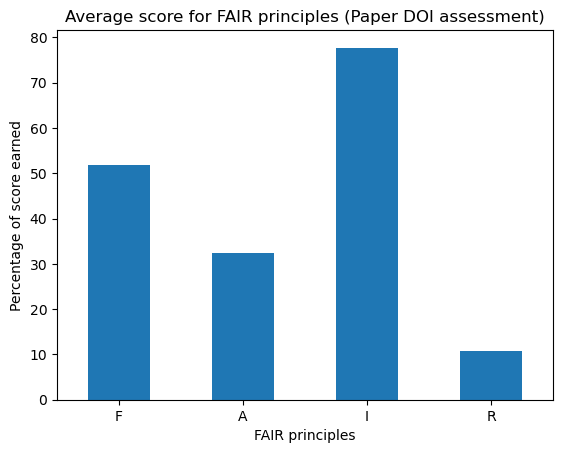

In [11]:
paper_doi_F_A_I_R["score_percent"].plot(kind="bar")
locs, labels = plt.xticks()
plt.xticks(locs, ["F", "A", "I", "R"], rotation=0)
plt.title("Average score for FAIR principles (Paper DOI assessment)")
plt.ylabel("Percentage of score earned")
plt.xlabel("FAIR principles")
plt.show()

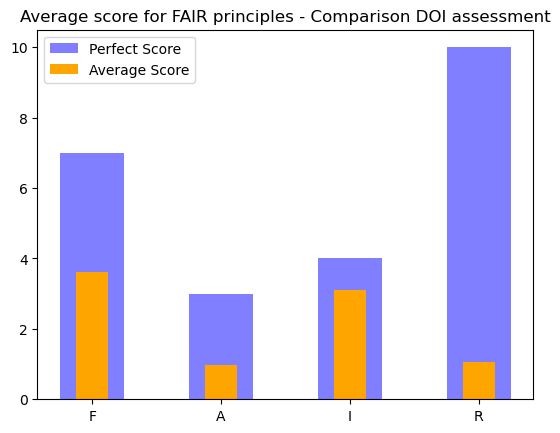

In [12]:
width = 0.5
perfect_scores = paper_doi_F_A_I_R["score_total"]
actual_scores = paper_doi_F_A_I_R['score_earned']
indices = np.arange(len(paper_doi_F_A_I_R['metric']))
plt.bar(indices, perfect_scores, width=width, color='b', alpha=0.5, label='Perfect Score')
plt.bar([i for i in indices], actual_scores, width=0.5*width, color='orange', label='Average Score')
plt.xticks(indices, paper_doi_F_A_I_R['metric'] )
plt.title("Average score for FAIR principles - Comparison DOI assessment")
plt.legend()
plt.show()

In [13]:
paper_doi_df_submetrics = paper_doi_df_assessed[np.logical_not((paper_doi_df_assessed['metric'] == "F") | (paper_doi_df_assessed['metric'] == "A") | (paper_doi_df_assessed['metric'] == "I") | (paper_doi_df_assessed['metric'] == "R") | (paper_doi_df_assessed['metric'] == "FAIR"))].reset_index(drop=True)

agg_funcs = {'maturity': 'mean', 'score_earned': 'mean', 'score_percent': 'mean', 'score_total': 'mean', 'status_passed': 'mean', 'status_total': 'mean'}
paper_doi_df_submetrics = paper_doi_df_submetrics.groupby("metric", as_index=False).agg(agg_funcs)

paper_doi_df_submetrics['metric'] = pd.Categorical(paper_doi_df_submetrics['metric'], ["F1", "F2", "F3", "F4", "A1", "I1", "I2", "I3", "R1", "R1.1", "R1.2", "R1.3"])
paper_doi_df_submetrics = paper_doi_df_submetrics.sort_values('metric').reset_index(drop=True)

paper_doi_df_submetrics

,metric,maturity,score_earned,score_percent,score_total,status_passed,status_total
0,F1,2.891908,1.945954,97.297708,2.0,1.891908,2.0
1,F2,1.732103,0.940681,47.034070,2.0,1.000000,1.0
2,F3,0.000000,0.000000,0.000000,1.0,0.000000,1.0
3,F4,1.942000,0.735348,36.767390,2.0,0.647333,1.0
4,A1,0.926384,0.969276,32.306743,3.0,1.012168,3.0
5,I1,2.996350,1.531738,76.586899,2.0,0.998783,1.0
6,I2,2.983776,0.994322,99.432164,1.0,0.994322,1.0
7,I3,1.677145,0.582843,58.284324,1.0,0.582843,1.0
8,R1,0.233421,0.233421,5.835530,4.0,0.000000,1.0
9,R1.1,0.046644,0.031434,1.571689,2.0,0.016224,1.0


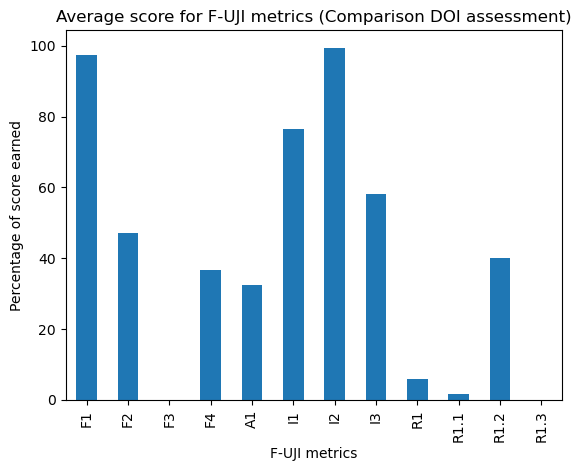

In [14]:
paper_doi_df_submetrics["score_percent"].plot(kind="bar")
locs, labels = plt.xticks()
plt.xticks(locs, ["F1", "F2", "F3", "F4", "A1", "I1", "I2", "I3", "R1", "R1.1", "R1.2", "R1.3"])
plt.title("Average score for F-UJI metrics (Comparison DOI assessment)")
plt.ylabel("Percentage of score earned")
plt.xlabel("F-UJI metrics")
plt.show()

## Paper evaluation via ORKG resource URL

### Paper assessment via ORKG resource URL

In [15]:
%%script false --no-raise-error
paper_url_df = pd.read_csv("raw_data/paper_query_result_2023-03-29.csv", encoding='ISO-8859-1').reset_index(drop=True)
paper_url_df = paper_url_df[["paper", "research_field_label"]].groupby("paper").agg({"research_field_label": "first"}).reset_index()
count = 0
paper_url_df["assessment_summary"] = paper_url_df["paper"].map(lambda x: get_assessment(x))
paper_url_df = paper_url_df[paper_url_df["assessment_summary"].isna() == False].reset_index(drop=True)
paper_url_df_split = split_summary(paper_url_df)
paper_url_df_assessed = extend_paper_df(paper_url_df_split)
paper_url_df_assessed.to_csv("assessed_data/paper_url_df_F-UJI_assessment.csv")
paper_url_df_assessed

Couldn't find program: 'false'


### Paper evaluation via ORKG resource URL + visualizations

In [16]:
paper_url_df_assessed = pd.read_csv("assessed_data/paper_url_df_F-UJI_assessment.csv", index_col=0)
paper_url_df_assessed

,paper,research_field_label,metric,maturity,score_earned,score_percent,score_total,status_passed,status_total
0,http://orkg.org/orkg/resource/R1004,Bioinformatics,A,0.0,0.0,0.00,3.0,0,3
1,http://orkg.org/orkg/resource/R1004,Bioinformatics,A1,0.0,0.0,0.00,3.0,0,3
2,http://orkg.org/orkg/resource/R1004,Bioinformatics,F,1.0,1.0,14.29,7.0,1,5
3,http://orkg.org/orkg/resource/R1004,Bioinformatics,F1,2.0,1.0,50.00,2.0,1,2
4,http://orkg.org/orkg/resource/R1004,Bioinformatics,F2,0.0,0.0,0.00,2.0,0,1
...,...,...,...,...,...,...,...,...,...
220842,http://orkg.org/orkg/resource/R9639,Computer Sciences,R,0.0,0.0,0.00,10.0,0,5
220843,http://orkg.org/orkg/resource/R9639,Computer Sciences,R1,0.0,0.0,0.00,4.0,0,1
220844,http://orkg.org/orkg/resource/R9639,Computer Sciences,R1.1,0.0,0.0,0.00,2.0,0,1
220845,http://orkg.org/orkg/resource/R9639,Computer Sciences,R1.2,0.0,0.0,0.00,2.0,0,1


In [17]:
paper_url_df_FAIR = paper_url_df_assessed[paper_url_df_assessed["metric"] == "FAIR"].reset_index(drop=True)
paper_url_df_FAIR

,paper,research_field_label,metric,maturity,score_earned,score_percent,score_total,status_passed,status_total
0,http://orkg.org/orkg/resource/R1004,Bioinformatics,FAIR,1.0,1.0,4.17,24.0,1,16
1,http://orkg.org/orkg/resource/R107618,Learner-Interface Interaction,FAIR,1.0,1.0,4.17,24.0,1,16
2,http://orkg.org/orkg/resource/R107663,Learner-Interface Interaction,FAIR,1.0,1.0,4.17,24.0,1,16
3,http://orkg.org/orkg/resource/R107834,Learner-Interface Interaction,FAIR,1.0,1.0,4.17,24.0,1,16
4,http://orkg.org/orkg/resource/R107843,Learner-Interface Interaction,FAIR,1.0,1.0,4.17,24.0,1,16
...,...,...,...,...,...,...,...,...,...
12986,http://orkg.org/orkg/resource/R8441,Systems Biology,FAIR,1.0,1.0,4.17,24.0,1,16
12987,http://orkg.org/orkg/resource/R9154,Life Sciences,FAIR,1.0,1.0,4.17,24.0,1,16
12988,http://orkg.org/orkg/resource/R9190,Biotechnology,FAIR,1.0,1.0,4.17,24.0,1,16
12989,http://orkg.org/orkg/resource/R9295,Biotechnology,FAIR,1.0,1.0,4.17,24.0,1,16


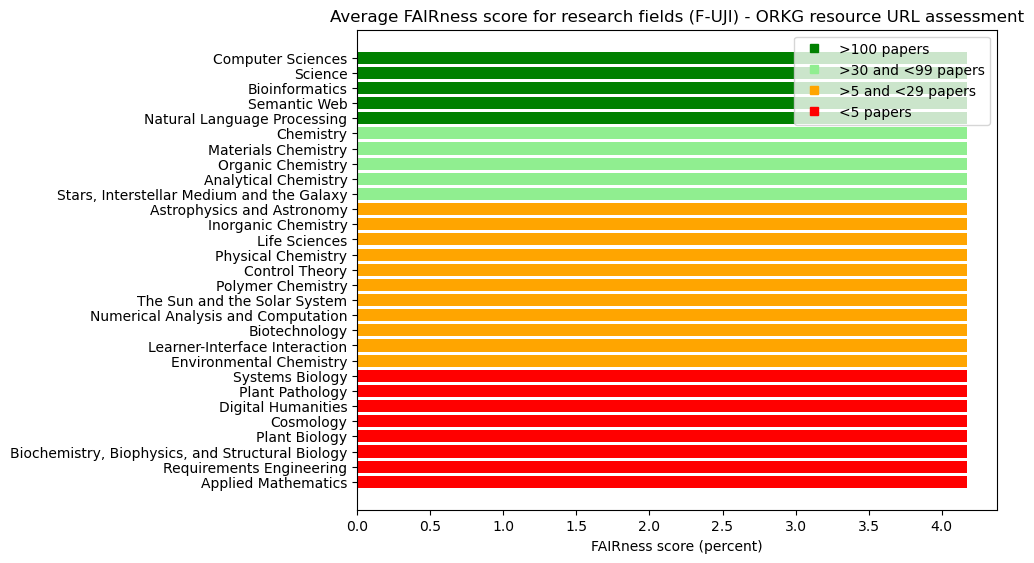

In [18]:
agg_funcs = {'score_earned': 'mean', 'score_percent': 'mean', 'score_total': 'mean', 'status_passed': 'mean', 'status_total': 'mean'}
paper_url_df_FAIR_fields = paper_url_df_FAIR.groupby("research_field_label").agg(agg_funcs)
paper_url_df_FAIR_fields["counts"] = paper_url_df_FAIR["research_field_label"].value_counts()
paper_url_df_FAIR_fields = paper_url_df_FAIR_fields.sort_values("counts")
paper_url_df_FAIR_fields = paper_url_df_FAIR_fields.reset_index()

plot = plt.figure()
ax = plot.add_axes([0,0,1,1])
fields = paper_url_df_FAIR_fields['research_field_label']
avg_scores = paper_url_df_FAIR_fields['score_percent']
counts_color = [{p<5: 'red', 5<=p<30: 'orange', 30<=p<=100: 'lightgreen', p>100: 'green'}[True] for p in paper_url_df_FAIR_fields["counts"]]
ax.barh(fields, avg_scores, color=counts_color)
leg_red = mlines.Line2D([], [], color="red", marker="s", ls='', label="<5 papers")
leg_orange = mlines.Line2D([], [], color="orange", marker="s", ls='', label=">5 and <29 papers")
leg_lightgreen = mlines.Line2D([], [], color="lightgreen", marker="s", ls='', label=">30 and <99 papers")
leg_green = mlines.Line2D([], [], color="green", marker="s", ls='', label=">100 papers")
plt.legend(handles=[leg_green, leg_lightgreen, leg_orange, leg_red])
plt.title("Average FAIRness score for research fields (F-UJI) - ORKG resource URL assessment")
plt.xlabel("FAIRness score (percent)")
plt.show()

In [19]:
paper_url_F_A_I_R = paper_url_df_assessed[(paper_url_df_assessed['metric'] == "F") | (paper_url_df_assessed['metric'] == "A") | (paper_url_df_assessed['metric'] == "I") | (paper_url_df_assessed['metric'] == "R")].reset_index(drop=True)

agg_funcs = {'maturity': 'mean', 'score_earned': 'mean', 'score_percent': 'mean', 'score_total': 'mean', 'status_passed': 'mean', 'status_total': 'mean'}
paper_url_F_A_I_R = paper_url_F_A_I_R.groupby("metric", as_index=False).agg(agg_funcs)

paper_url_F_A_I_R['metric'] = pd.Categorical(paper_url_F_A_I_R['metric'], ["F", "A", "I", "R"])
paper_url_F_A_I_R = paper_url_F_A_I_R.sort_values('metric').reset_index(drop=True)

paper_url_F_A_I_R

,metric,maturity,score_earned,score_percent,score_total,status_passed,status_total
0,F,1.0,1.0,14.29,7.0,1.0,5.0
1,A,0.0,0.0,0.00,3.0,0.0,3.0
2,I,0.0,0.0,0.00,4.0,0.0,3.0
3,R,0.0,0.0,0.00,10.0,0.0,5.0


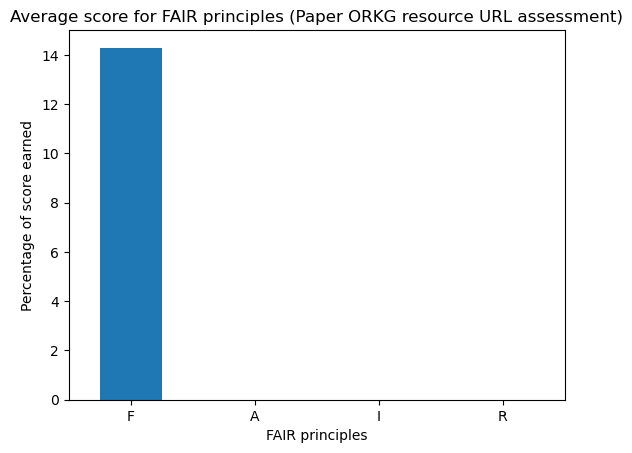

In [20]:
paper_url_F_A_I_R["score_percent"].plot(kind="bar")
locs, labels = plt.xticks()
plt.xticks(locs, ["F", "A", "I", "R"], rotation=0)
plt.title("Average score for FAIR principles (Paper ORKG resource URL assessment)")
plt.ylabel("Percentage of score earned")
plt.xlabel("FAIR principles")
plt.show()

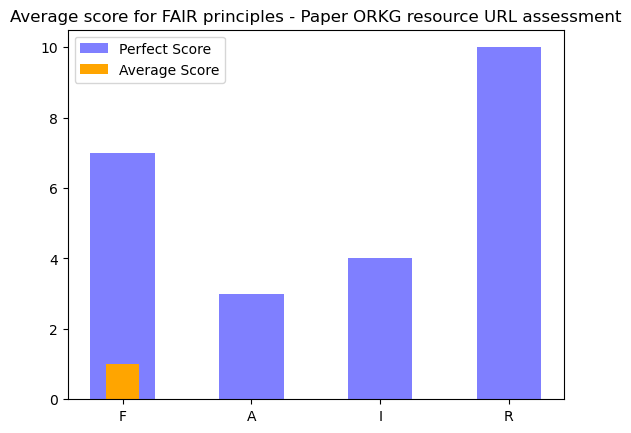

In [21]:
width = 0.5
perfect_scores = paper_url_F_A_I_R["score_total"]
actual_scores = paper_url_F_A_I_R['score_earned']
indices = np.arange(len(paper_url_F_A_I_R['metric']))
plt.bar(indices, perfect_scores, width=width, color='b', alpha=0.5, label='Perfect Score')
plt.bar([i for i in indices], actual_scores, width=0.5*width, color='orange', label='Average Score')
plt.xticks(indices, paper_url_F_A_I_R['metric'] )
plt.title("Average score for FAIR principles - Paper ORKG resource URL assessment")
plt.legend()
plt.show()

In [22]:
paper_url_df_submetrics = paper_url_df_assessed[np.logical_not((paper_url_df_assessed['metric'] == "F") | (paper_url_df_assessed['metric'] == "A") | (paper_url_df_assessed['metric'] == "I") | (paper_url_df_assessed['metric'] == "R") | (paper_url_df_assessed['metric'] == "FAIR"))].reset_index(drop=True)

agg_funcs = {'maturity': 'mean', 'score_earned': 'mean', 'score_percent': 'mean', 'score_total': 'mean', 'status_passed': 'mean', 'status_total': 'mean'}
paper_url_df_submetrics = paper_url_df_submetrics.groupby("metric", as_index=False).agg(agg_funcs)

paper_url_df_submetrics['metric'] = pd.Categorical(paper_url_df_submetrics['metric'], ["F1", "F2", "F3", "F4", "A1", "I1", "I2", "I3", "R1", "R1.1", "R1.2", "R1.3"])
paper_url_df_submetrics = paper_url_df_submetrics.sort_values('metric').reset_index(drop=True)

paper_url_df_submetrics

,metric,maturity,score_earned,score_percent,score_total,status_passed,status_total
0,F1,2.0,1.0,50.0,2.0,1.0,2.0
1,F2,0.0,0.0,0.0,2.0,0.0,1.0
2,F3,0.0,0.0,0.0,1.0,0.0,1.0
3,F4,0.0,0.0,0.0,2.0,0.0,1.0
4,A1,0.0,0.0,0.0,3.0,0.0,3.0
5,I1,0.0,0.0,0.0,2.0,0.0,1.0
6,I2,0.0,0.0,0.0,1.0,0.0,1.0
7,I3,0.0,0.0,0.0,1.0,0.0,1.0
8,R1,0.0,0.0,0.0,4.0,0.0,1.0
9,R1.1,0.0,0.0,0.0,2.0,0.0,1.0


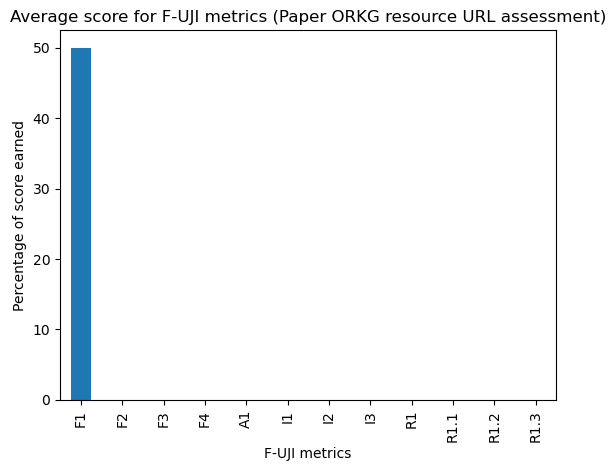

In [23]:
paper_url_df_submetrics["score_percent"].plot(kind="bar")
locs, labels = plt.xticks()
plt.xticks(locs, ["F1", "F2", "F3", "F4", "A1", "I1", "I2", "I3", "R1", "R1.1", "R1.2", "R1.3"])
plt.title("Average score for F-UJI metrics (Paper ORKG resource URL assessment)")
plt.ylabel("Percentage of score earned")
plt.xlabel("F-UJI metrics")
plt.show()

## Paper evaluation via standard URL

### Paper assessment via standard URL

In [42]:
%%script false --no-raise-error
paper_stdurl_df = pd.read_csv("raw_data/paper_query_result_2023-03-29.csv", encoding='ISO-8859-1').reset_index(drop=True)
paper_stdurl_df = paper_stdurl_df[["paper", "research_field_label", "url"]].groupby("paper").agg({"research_field_label": "first", "url": "first"}).reset_index()
paper_stdurl_df = paper_stdurl_df[paper_stdurl_df["url"].isna() == False].reset_index(drop=True)
count = 0
paper_stdurl_df["assessment_summary"] = paper_stdurl_df["url"].map(lambda x: get_assessment(x))
paper_stdurl_df = paper_stdurl_df[paper_stdurl_df["assessment_summary"].isna() == False].reset_index(drop=True)
paper_stdurl_df_split = split_summary(paper_stdurl_df)
paper_stdurl_df_assessed = extend_paper_df(paper_stdurl_df_split)
paper_stdurl_df_assessed.to_csv("assessed_data/paper_stdurl_df_F-UJI_assessment.csv")
paper_stdurl_df_assessed

Couldn't find program: 'false'


### Paper evaluation via standard URL + visualizations

In [44]:
paper_stdurl_df_assessed = pd.read_csv("assessed_data/paper_stdurl_df_F-UJI_assessment.csv")
paper_stdurl_df_assessed

,Unnamed: 0,paper,research_field_label,metric,maturity,score_earned,score_percent,score_total,status_passed,status_total
0,0,http://orkg.org/orkg/resource/R107834,Learner-Interface Interaction,A,0.0,0.0,0.00,3.0,0,3
1,1,http://orkg.org/orkg/resource/R107834,Learner-Interface Interaction,A1,0.0,0.0,0.00,3.0,0,3
2,2,http://orkg.org/orkg/resource/R107834,Learner-Interface Interaction,F,1.0,1.0,14.29,7.0,1,5
3,3,http://orkg.org/orkg/resource/R107834,Learner-Interface Interaction,F1,2.0,1.0,50.00,2.0,1,2
4,4,http://orkg.org/orkg/resource/R107834,Learner-Interface Interaction,F2,0.0,0.0,0.00,2.0,0,1
...,...,...,...,...,...,...,...,...,...,...
137049,137049,http://orkg.org/orkg/resource/R78345,Physical Chemistry,R,0.0,0.0,0.00,10.0,0,5
137050,137050,http://orkg.org/orkg/resource/R78345,Physical Chemistry,R1,0.0,0.0,0.00,4.0,0,1
137051,137051,http://orkg.org/orkg/resource/R78345,Physical Chemistry,R1.1,0.0,0.0,0.00,2.0,0,1
137052,137052,http://orkg.org/orkg/resource/R78345,Physical Chemistry,R1.2,0.0,0.0,0.00,2.0,0,1


In [45]:
paper_stdurl_df_FAIR = paper_stdurl_df_assessed[paper_stdurl_df_assessed["metric"] == "FAIR"].reset_index(drop=True)
paper_stdurl_df_FAIR

,Unnamed: 0,paper,research_field_label,metric,maturity,score_earned,score_percent,score_total,status_passed,status_total
0,7,http://orkg.org/orkg/resource/R107834,Learner-Interface Interaction,FAIR,1.00,1.0,4.17,24.0,1,16
1,24,http://orkg.org/orkg/resource/R107843,Learner-Interface Interaction,FAIR,1.25,5.5,22.92,24.0,7,16
2,41,http://orkg.org/orkg/resource/R108529,Computer Sciences,FAIR,1.50,9.0,37.50,24.0,9,16
3,58,http://orkg.org/orkg/resource/R108693,Biotechnology,FAIR,1.75,11.5,47.92,24.0,11,16
4,75,http://orkg.org/orkg/resource/R108704,Plant Pathology,FAIR,1.75,9.5,39.58,24.0,11,16
...,...,...,...,...,...,...,...,...,...,...
8057,136976,http://orkg.org/orkg/resource/R78136,Life Sciences,FAIR,1.00,1.0,4.17,24.0,1,16
8058,136993,http://orkg.org/orkg/resource/R78139,Life Sciences,FAIR,1.00,1.0,4.17,24.0,1,16
8059,137010,http://orkg.org/orkg/resource/R78145,Life Sciences,FAIR,1.00,1.0,4.17,24.0,1,16
8060,137027,http://orkg.org/orkg/resource/R78301,Environmental Chemistry,FAIR,1.75,9.5,39.58,24.0,11,16


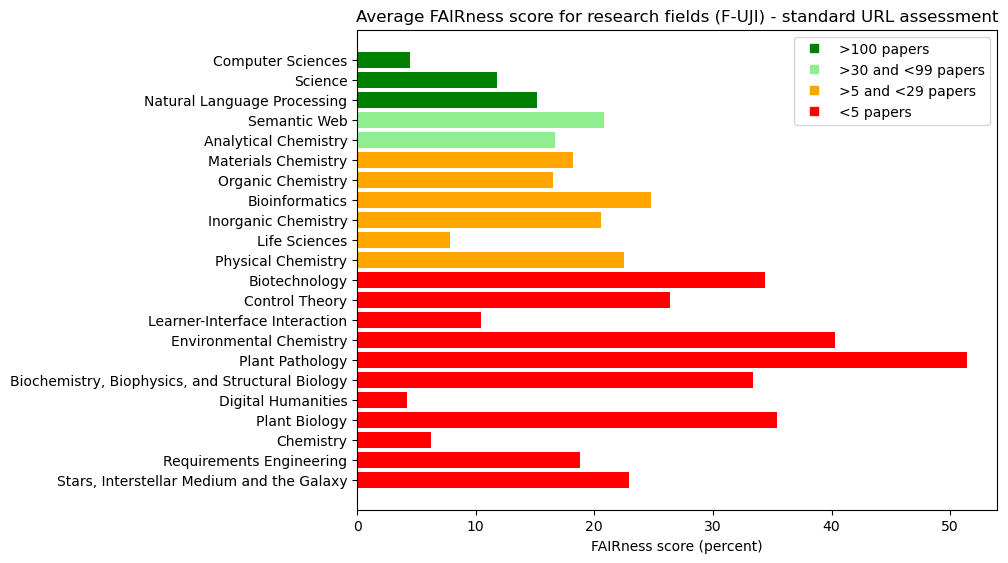

In [56]:
agg_funcs = {'score_earned': 'mean', 'score_percent': 'mean', 'score_total': 'mean', 'status_passed': 'mean', 'status_total': 'mean'}
paper_stdurl_df_FAIR_fields = paper_stdurl_df_FAIR.groupby("research_field_label").agg(agg_funcs)
paper_stdurl_df_FAIR_fields["counts"] = paper_stdurl_df_FAIR["research_field_label"].value_counts()
paper_stdurl_df_FAIR_fields = paper_stdurl_df_FAIR_fields.sort_values("counts")
paper_stdurl_df_FAIR_fields = paper_stdurl_df_FAIR_fields.reset_index()

plot = plt.figure()
ax = plot.add_axes([0,0,1,1])
fields = paper_stdurl_df_FAIR_fields['research_field_label']
avg_scores = paper_stdurl_df_FAIR_fields['score_percent']
counts_color = [{p<5: 'red', 5<=p<30: 'orange', 30<=p<=100: 'lightgreen', p>100: 'green'}[True] for p in paper_stdurl_df_FAIR_fields["counts"]]
ax.barh(fields, avg_scores, color=counts_color)
leg_red = mlines.Line2D([], [], color="red", marker="s", ls='', label="<5 papers")
leg_orange = mlines.Line2D([], [], color="orange", marker="s", ls='', label=">5 and <29 papers")
leg_lightgreen = mlines.Line2D([], [], color="lightgreen", marker="s", ls='', label=">30 and <99 papers")
leg_green = mlines.Line2D([], [], color="green", marker="s", ls='', label=">100 papers")
plt.legend(handles=[leg_green, leg_lightgreen, leg_orange, leg_red])
plt.title("Average FAIRness score for research fields (F-UJI) - standard URL assessment")
plt.xlabel("FAIRness score (percent)")
plt.show()

In [48]:
paper_stdurl_F_A_I_R = paper_stdurl_df_assessed[(paper_stdurl_df_assessed['metric'] == "F") | (paper_stdurl_df_assessed['metric'] == "A") | (paper_stdurl_df_assessed['metric'] == "I") | (paper_stdurl_df_assessed['metric'] == "R")].reset_index(drop=True)

agg_funcs = {'maturity': 'mean', 'score_earned': 'mean', 'score_percent': 'mean', 'score_total': 'mean', 'status_passed': 'mean', 'status_total': 'mean'}
paper_stdurl_F_A_I_R = paper_stdurl_F_A_I_R.groupby("metric", as_index=False).agg(agg_funcs)

paper_stdurl_F_A_I_R['metric'] = pd.Categorical(paper_stdurl_F_A_I_R['metric'], ["F", "A", "I", "R"])
paper_stdurl_F_A_I_R = paper_stdurl_F_A_I_R.sort_values('metric').reset_index(drop=True)

paper_stdurl_F_A_I_R

,metric,maturity,score_earned,score_percent,score_total,status_passed,status_total
0,F,1.019226,1.142955,16.331666,7.0,1.162739,5.0
1,A,0.088316,0.090052,3.001496,3.0,0.091789,3.0
2,I,0.060655,0.069338,1.733441,4.0,0.059663,3.0
3,R,0.083354,0.088440,0.884396,10.0,0.108906,5.0


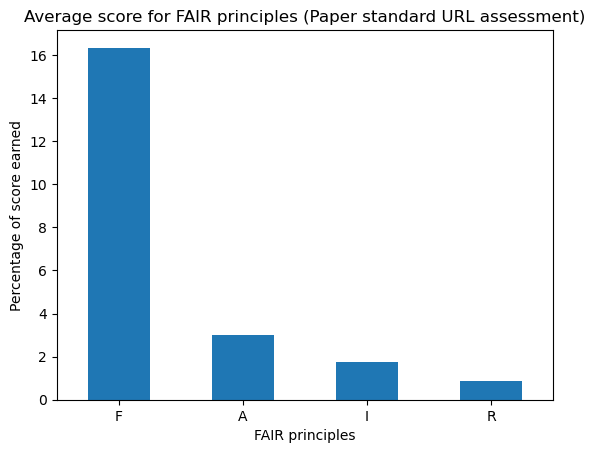

In [55]:
paper_stdurl_F_A_I_R["score_percent"].plot(kind="bar")
locs, labels = plt.xticks()
plt.xticks(locs, ["F", "A", "I", "R"], rotation=0)
plt.title("Average score for FAIR principles (Paper standard URL assessment)")
plt.ylabel("Percentage of score earned")
plt.xlabel("FAIR principles")
plt.show()

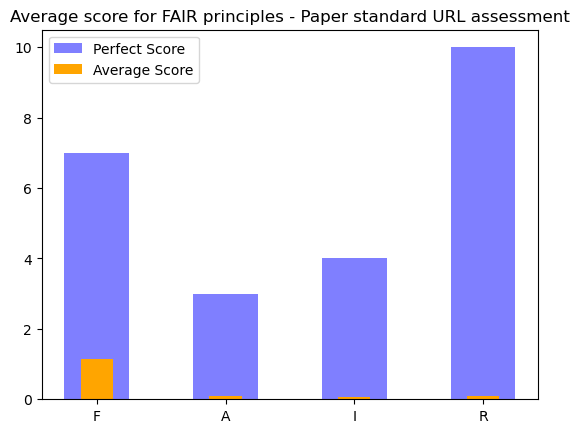

In [54]:
width = 0.5
perfect_scores = paper_stdurl_F_A_I_R["score_total"]
actual_scores = paper_stdurl_F_A_I_R['score_earned']
indices = np.arange(len(paper_stdurl_F_A_I_R['metric']))
plt.bar(indices, perfect_scores, width=width, color='b', alpha=0.5, label='Perfect Score')
plt.bar([i for i in indices], actual_scores, width=0.5*width, color='orange', label='Average Score')
plt.xticks(indices, paper_stdurl_F_A_I_R['metric'] )
plt.title("Average score for FAIR principles - Paper standard URL assessment")
plt.legend()
plt.show()

In [51]:
paper_stdurl_df_submetrics = paper_stdurl_df_assessed[np.logical_not((paper_stdurl_df_assessed['metric'] == "F") | (paper_stdurl_df_assessed['metric'] == "A") | (paper_stdurl_df_assessed['metric'] == "I") | (paper_stdurl_df_assessed['metric'] == "R") | (paper_stdurl_df_assessed['metric'] == "FAIR"))].reset_index(drop=True)

agg_funcs = {'maturity': 'mean', 'score_earned': 'mean', 'score_percent': 'mean', 'score_total': 'mean', 'status_passed': 'mean', 'status_total': 'mean'}
paper_stdurl_df_submetrics = paper_stdurl_df_submetrics.groupby("metric", as_index=False).agg(agg_funcs)

paper_stdurl_df_submetrics['metric'] = pd.Categorical(paper_stdurl_df_submetrics['metric'], ["F1", "F2", "F3", "F4", "A1", "I1", "I2", "I3", "R1", "R1.1", "R1.2", "R1.3"])
paper_stdurl_df_submetrics = paper_stdurl_df_submetrics.sort_values('metric').reset_index(drop=True)

paper_stdurl_df_submetrics

,metric,maturity,score_earned,score_percent,score_total,status_passed,status_total
0,F1,2.019970,1.025676,51.283801,2.0,1.021211,2.0
1,F2,0.112007,0.060097,3.004838,2.0,0.084718,1.0
2,F3,0.000000,0.000000,0.000000,1.0,0.000000,1.0
3,F4,0.170429,0.057182,2.859092,2.0,0.056810,1.0
4,A1,0.088316,0.090052,3.001496,3.0,0.091789,3.0
5,I1,0.070454,0.033863,1.693128,2.0,0.024188,1.0
6,I2,0.068966,0.022079,2.207889,1.0,0.022079,1.0
7,I3,0.036591,0.013396,1.339618,1.0,0.013396,1.0
8,R1,0.038080,0.038080,0.951997,4.0,0.000000,1.0
9,R1.1,0.005706,0.003845,0.192260,2.0,0.001985,1.0


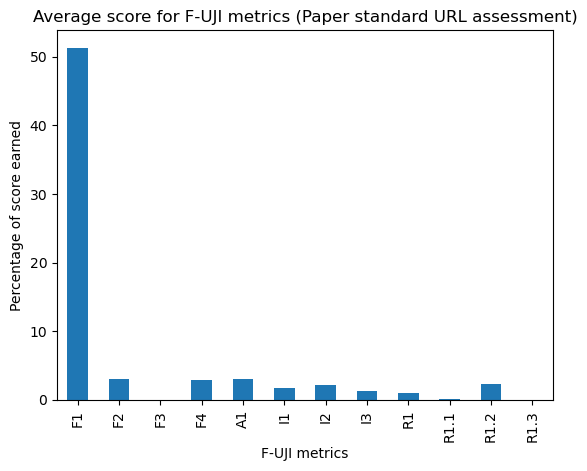

In [53]:
paper_stdurl_df_submetrics["score_percent"].plot(kind="bar")
locs, labels = plt.xticks()
plt.xticks(locs, ["F1", "F2", "F3", "F4", "A1", "I1", "I2", "I3", "R1", "R1.1", "R1.2", "R1.3"])
plt.title("Average score for F-UJI metrics (Paper standard URL assessment)")
plt.ylabel("Percentage of score earned")
plt.xlabel("F-UJI metrics")
plt.show()

# Comparisons

In [16]:
def extend_comp_df(df):
    df_ext = pd.DataFrame()

    df_ext['comparison'] = list(chain.from_iterable([[x]*17 for x in df['comparisons']]))
    df_ext['doi'] = list(chain.from_iterable([[x]*17 for x in df['doi']]))
    df_ext['metric'] = list(chain.from_iterable(list(x.keys()) for x in df['maturity']))
    df_ext['maturity'] = list(chain.from_iterable(x.values() for x in df['maturity']))
    df_ext['score_earned'] = list(chain.from_iterable(x.values() for x in df['score_earned']))
    df_ext['score_percent'] = list(chain.from_iterable(x.values() for x in df['score_percent']))
    df_ext['score_total'] = list(chain.from_iterable(x.values() for x in df['score_total']))
    df_ext['status_passed'] = list(chain.from_iterable(x.values() for x in df['status_passed']))
    df_ext['status_total'] = list(chain.from_iterable(x.values() for x in df['status_total']))

    return df_ext

## Comparison evaluation via DOI

### Comparison assessment via DOI

In [17]:
%%script false --no-raise-error
comp_doi_df = pd.read_csv("raw_data/comparison_query_result_2023-03-29.csv")
comp_doi_df = comp_doi_df[comp_doi_df["doi"].isna() == False].reset_index(drop=True)
count = 0
comp_doi_df["assessment_summary"] = comp_doi_df["doi"].map(lambda x: get_assessment("https://doi.org/" + x))
comp_doi_df

Couldn't find program: 'false'


In [18]:
%%script false --no-raise-error
comp_doi_df_split = split_summary(comp_doi_df)
comp_doi_df_assessed = extend_comp_df(comp_doi_df_split)
comp_doi_df_assessed.to_csv("assessed_data/comparison_doi_df_F-UJI_assessment.csv")
comp_doi_df_assessed

Couldn't find program: 'false'


### Comparisons evaluation via DOI + visualizations

In [19]:
comp_doi_df_assessed = pd.read_csv("assessed_data/comparison_doi_df_F-UJI_assessment.csv", index_col=0)
comp_doi_df_assessed

,comparison,doi,metric,maturity,score_earned,score_percent,score_total,status_passed,status_total
0,http://orkg.org/orkg/resource/R140347,10.48366/r140347,A,1.0,1.0,33.33,3.0,1,3
1,http://orkg.org/orkg/resource/R140347,10.48366/r140347,A1,1.0,1.0,33.33,3.0,1,3
2,http://orkg.org/orkg/resource/R140347,10.48366/r140347,F,2.0,6.0,85.71,7.0,4,5
3,http://orkg.org/orkg/resource/R140347,10.48366/r140347,F1,3.0,2.0,100.00,2.0,2,2
4,http://orkg.org/orkg/resource/R140347,10.48366/r140347,F2,3.0,2.0,100.00,2.0,1,1
...,...,...,...,...,...,...,...,...,...
4993,http://orkg.org/orkg/resource/R576876,10.48366/r576876,R,1.0,4.0,40.00,10.0,2,5
4994,http://orkg.org/orkg/resource/R576876,10.48366/r576876,R1,1.0,1.0,25.00,4.0,0,1
4995,http://orkg.org/orkg/resource/R576876,10.48366/r576876,R1.1,3.0,2.0,100.00,2.0,1,1
4996,http://orkg.org/orkg/resource/R576876,10.48366/r576876,R1.2,2.0,1.0,50.00,2.0,1,1


In [20]:
comp_doi_df_FAIR = comp_doi_df_assessed[comp_doi_df_assessed["metric"] == "FAIR"].reset_index(drop=True)
comp_doi_df_FAIR

,comparison,doi,metric,maturity,score_earned,score_percent,score_total,status_passed,status_total
0,http://orkg.org/orkg/resource/R140347,10.48366/r140347,FAIR,1.25,12.0,50.0,24.0,8,16
1,http://orkg.org/orkg/resource/R140449,10.48366/r140449,FAIR,1.25,12.0,50.0,24.0,8,16
2,http://orkg.org/orkg/resource/R140463,10.48366/r140463,FAIR,1.25,12.0,50.0,24.0,8,16
3,http://orkg.org/orkg/resource/R140465,10.48366/r140465,FAIR,1.25,12.0,50.0,24.0,8,16
4,http://orkg.org/orkg/resource/R140714,10.48366/r140714,FAIR,1.25,12.0,50.0,24.0,8,16
...,...,...,...,...,...,...,...,...,...
289,http://orkg.org/orkg/resource/R576872,10.48366/r576872,FAIR,1.25,12.0,50.0,24.0,8,16
290,http://orkg.org/orkg/resource/R576873,10.48366/r576873,FAIR,1.25,12.0,50.0,24.0,8,16
291,http://orkg.org/orkg/resource/R576874,10.48366/r576874,FAIR,1.25,12.0,50.0,24.0,8,16
292,http://orkg.org/orkg/resource/R576875,10.48366/r576875,FAIR,1.25,12.0,50.0,24.0,8,16


In [21]:
comp_doi_F_A_I_R = comp_doi_df_assessed[(comp_doi_df_assessed['metric'] == "F") | (comp_doi_df_assessed['metric'] == "A") | (comp_doi_df_assessed['metric'] == "I") | (comp_doi_df_assessed['metric'] == "R")].reset_index(drop=True)

agg_funcs = {'maturity': 'mean', 'score_earned': 'mean', 'score_percent': 'mean', 'score_total': 'mean', 'status_passed': 'mean', 'status_total': 'mean'}
comp_doi_F_A_I_R = comp_doi_F_A_I_R.groupby("metric", as_index=False).agg(agg_funcs)

comp_doi_F_A_I_R['metric'] = pd.Categorical(comp_doi_F_A_I_R['metric'], ["F", "A", "I", "R"])
comp_doi_F_A_I_R = comp_doi_F_A_I_R.sort_values('metric').reset_index(drop=True)

comp_doi_F_A_I_R

,metric,maturity,score_earned,score_percent,score_total,status_passed,status_total
0,F,2.0,5.964286,85.20,7.0,4.0,5.0
1,A,1.0,1.000000,33.33,3.0,1.0,3.0
2,I,1.0,1.000000,25.00,4.0,1.0,3.0
3,R,1.0,4.000000,40.00,10.0,2.0,5.0


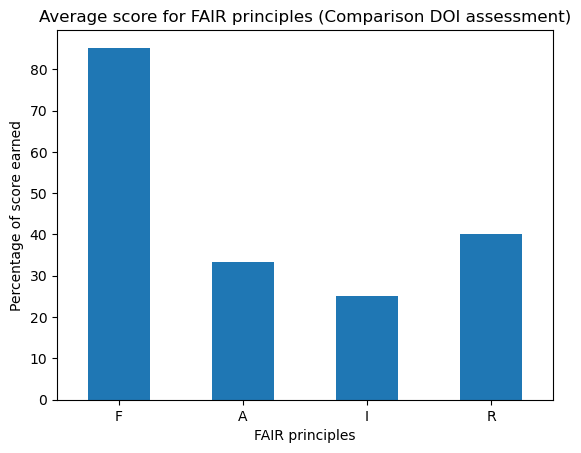

In [22]:
comp_doi_F_A_I_R["score_percent"].plot(kind="bar")
locs, labels = plt.xticks()
plt.xticks(locs, ["F", "A", "I", "R"], rotation=0)
plt.title("Average score for FAIR principles (Comparison DOI assessment)")
plt.ylabel("Percentage of score earned")
plt.xlabel("FAIR principles")
plt.show()

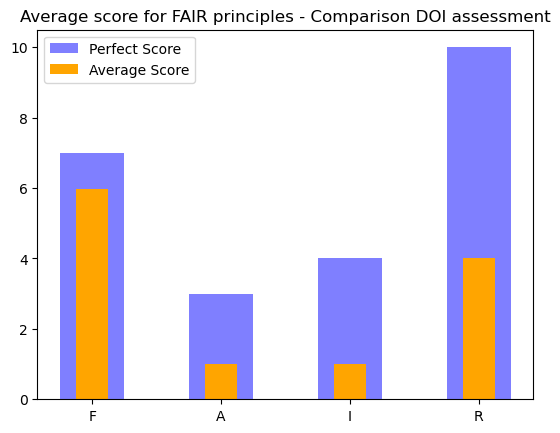

In [23]:
width = 0.5
perfect_scores = comp_doi_F_A_I_R["score_total"]
actual_scores = comp_doi_F_A_I_R['score_earned']
indices = np.arange(len(comp_doi_F_A_I_R['metric']))
plt.bar(indices, perfect_scores, width=width, color='b', alpha=0.5, label='Perfect Score')
plt.bar([i for i in indices], actual_scores, width=0.5*width, color='orange', label='Average Score')
plt.xticks(indices, comp_doi_F_A_I_R['metric'] )
plt.title("Average score for FAIR principles - Comparison DOI assessment")
plt.legend()
plt.show()

In [24]:
comp_doi_df_submetrics = comp_doi_df_assessed[np.logical_not((comp_doi_df_assessed['metric'] == "F") | (comp_doi_df_assessed['metric'] == "A") | (comp_doi_df_assessed['metric'] == "I") | (comp_doi_df_assessed['metric'] == "R") | (comp_doi_df_assessed['metric'] == "FAIR"))].reset_index(drop=True)

agg_funcs = {'maturity': 'mean', 'score_earned': 'mean', 'score_percent': 'mean', 'score_total': 'mean', 'status_passed': 'mean', 'status_total': 'mean'}
comp_doi_df_submetrics = comp_doi_df_submetrics.groupby("metric", as_index=False).agg(agg_funcs)

comp_doi_df_submetrics['metric'] = pd.Categorical(comp_doi_df_submetrics['metric'], ["F1", "F2", "F3", "F4", "A1", "I1", "I2", "I3", "R1", "R1.1", "R1.2", "R1.3"])
comp_doi_df_submetrics = comp_doi_df_submetrics.sort_values('metric').reset_index(drop=True)

comp_doi_df_submetrics

,metric,maturity,score_earned,score_percent,score_total,status_passed,status_total
0,F1,3.000000,2.000000,100.000000,2.0,2.0,2.0
1,F2,2.962585,1.964286,98.214286,2.0,1.0,1.0
2,F3,0.000000,0.000000,0.000000,1.0,0.0,1.0
3,F4,3.000000,2.000000,100.000000,2.0,1.0,1.0
4,A1,1.000000,1.000000,33.330000,3.0,1.0,3.0
5,I1,3.000000,1.000000,50.000000,2.0,1.0,1.0
6,I2,0.000000,0.000000,0.000000,1.0,0.0,1.0
7,I3,0.000000,0.000000,0.000000,1.0,0.0,1.0
8,R1,1.000000,1.000000,25.000000,4.0,0.0,1.0
9,R1.1,3.000000,2.000000,100.000000,2.0,1.0,1.0


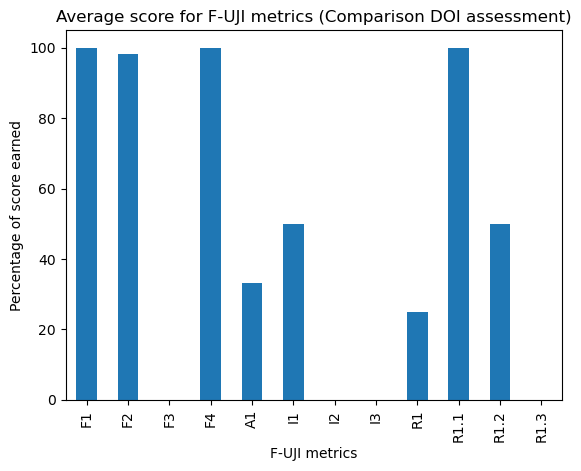

In [25]:
comp_doi_df_submetrics["score_percent"].plot(kind="bar")
locs, labels = plt.xticks()
plt.xticks(locs, ["F1", "F2", "F3", "F4", "A1", "I1", "I2", "I3", "R1", "R1.1", "R1.2", "R1.3"])
plt.title("Average score for F-UJI metrics (Comparison DOI assessment)")
plt.ylabel("Percentage of score earned")
plt.xlabel("F-UJI metrics")
plt.show()

## Comparison evaluation via ORKG resource URL

### Comparison assessment via ORKG resource URL

In [26]:
%%script false --no-raise-error
comp_url_df = pd.read_csv("raw_data/comparison_query_result_2023-03-29.csv")
count = 0
comp_url_df["assessment_summary"] = comp_url_df["comparisons"].map(lambda x: get_assessment(x))
comp_url_df_split = split_summary(comp_url_df)
comp_url_df_assessed = extend_comp_df(comp_url_df_split)
comp_url_df_assessed.to_csv("assessed_data/comparison_url_df_F-UJI_assessment.csv")
comp_url_df_assessed

Couldn't find program: 'false'


### Comparisons evaluation via ORKG resource URL + visualizations

In [27]:
comp_url_df_assessed = pd.read_csv("assessed_data/comparison_url_df_F-UJI_assessment.csv", index_col=0)
comp_url_df_assessed

,comparison,doi,metric,maturity,score_earned,score_percent,score_total,status_passed,status_total
0,http://orkg.org/orkg/resource/R140347,10.48366/r140347,A,0.0,0.0,0.00,3.0,0,3
1,http://orkg.org/orkg/resource/R140347,10.48366/r140347,A1,0.0,0.0,0.00,3.0,0,3
2,http://orkg.org/orkg/resource/R140347,10.48366/r140347,F,1.0,1.0,14.29,7.0,1,5
3,http://orkg.org/orkg/resource/R140347,10.48366/r140347,F1,2.0,1.0,50.00,2.0,1,2
4,http://orkg.org/orkg/resource/R140347,10.48366/r140347,F2,0.0,0.0,0.00,2.0,0,1
...,...,...,...,...,...,...,...,...,...
19528,http://orkg.org/orkg/resource/R288673,NaN,R,0.0,0.0,0.00,10.0,0,5
19529,http://orkg.org/orkg/resource/R288673,NaN,R1,0.0,0.0,0.00,4.0,0,1
19530,http://orkg.org/orkg/resource/R288673,NaN,R1.1,0.0,0.0,0.00,2.0,0,1
19531,http://orkg.org/orkg/resource/R288673,NaN,R1.2,0.0,0.0,0.00,2.0,0,1


In [28]:
comp_url_df_FAIR = comp_url_df_assessed[comp_url_df_assessed["metric"] == "FAIR"].reset_index(drop=True)
comp_url_df_FAIR

,comparison,doi,metric,maturity,score_earned,score_percent,score_total,status_passed,status_total
0,http://orkg.org/orkg/resource/R140347,10.48366/r140347,FAIR,1.0,1.0,4.17,24.0,1,16
1,http://orkg.org/orkg/resource/R140449,10.48366/r140449,FAIR,1.0,1.0,4.17,24.0,1,16
2,http://orkg.org/orkg/resource/R140463,10.48366/r140463,FAIR,1.0,1.0,4.17,24.0,1,16
3,http://orkg.org/orkg/resource/R140465,10.48366/r140465,FAIR,1.0,1.0,4.17,24.0,1,16
4,http://orkg.org/orkg/resource/R140714,10.48366/r140714,FAIR,1.0,1.0,4.17,24.0,1,16
...,...,...,...,...,...,...,...,...,...
1144,http://orkg.org/orkg/resource/R203903,NaN,FAIR,1.0,1.0,4.17,24.0,1,16
1145,http://orkg.org/orkg/resource/R204005,NaN,FAIR,1.0,1.0,4.17,24.0,1,16
1146,http://orkg.org/orkg/resource/R288079,NaN,FAIR,1.0,1.0,4.17,24.0,1,16
1147,http://orkg.org/orkg/resource/R288672,NaN,FAIR,1.0,1.0,4.17,24.0,1,16


In [29]:
comp_url_F_A_I_R = comp_url_df_assessed[(comp_url_df_assessed['metric'] == "F") | (comp_url_df_assessed['metric'] == "A") | (comp_url_df_assessed['metric'] == "I") | (comp_url_df_assessed['metric'] == "R")].reset_index(drop=True)

agg_funcs = {'maturity': 'mean', 'score_earned': 'mean', 'score_percent': 'mean', 'score_total': 'mean', 'status_passed': 'mean', 'status_total': 'mean'}
comp_url_F_A_I_R = comp_url_F_A_I_R.groupby("metric", as_index=False).agg(agg_funcs)

comp_url_F_A_I_R['metric'] = pd.Categorical(comp_url_F_A_I_R['metric'], ["F", "A", "I", "R"])
comp_url_F_A_I_R = comp_url_F_A_I_R.sort_values('metric').reset_index(drop=True)

comp_url_F_A_I_R

,metric,maturity,score_earned,score_percent,score_total,status_passed,status_total
0,F,1.0,1.0,14.29,7.0,1.0,5.0
1,A,0.0,0.0,0.00,3.0,0.0,3.0
2,I,0.0,0.0,0.00,4.0,0.0,3.0
3,R,0.0,0.0,0.00,10.0,0.0,5.0


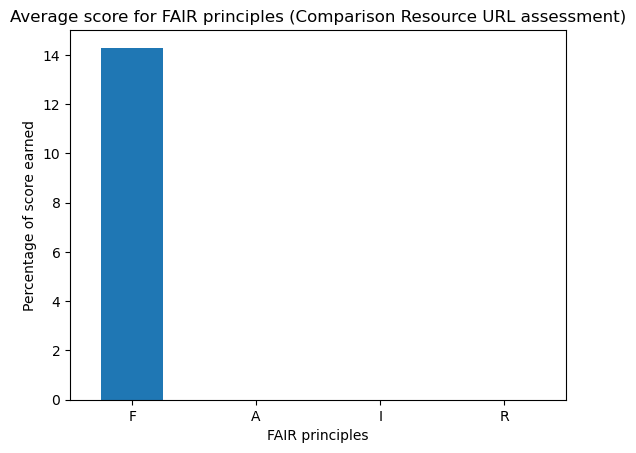

In [30]:
comp_url_F_A_I_R["score_percent"].plot(kind="bar")
locs, labels = plt.xticks()
plt.xticks(locs, ["F", "A", "I", "R"], rotation=0)
plt.title("Average score for FAIR principles (Comparison Resource URL assessment)")
plt.ylabel("Percentage of score earned")
plt.xlabel("FAIR principles")
plt.show()

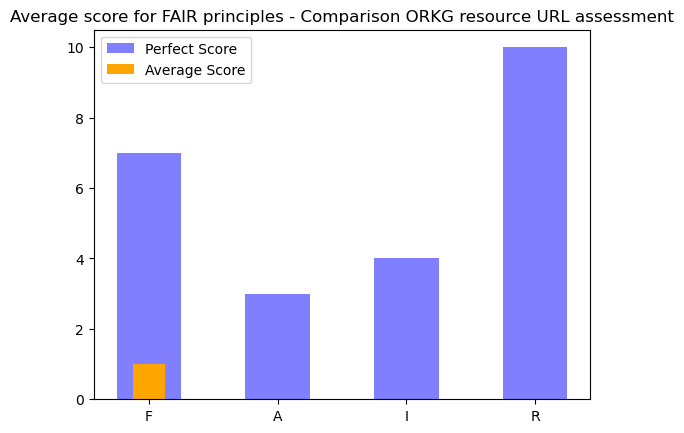

In [31]:
width = 0.5
perfect_scores = comp_url_F_A_I_R["score_total"]
actual_scores = comp_url_F_A_I_R['score_earned']
indices = np.arange(len(comp_url_F_A_I_R['metric']))
plt.bar(indices, perfect_scores, width=width, color='b', alpha=0.5, label='Perfect Score')
plt.bar([i for i in indices], actual_scores, width=0.5*width, color='orange', label='Average Score')
plt.xticks(indices, comp_url_F_A_I_R['metric'] )
plt.title("Average score for FAIR principles - Comparison ORKG resource URL assessment")
plt.legend()
plt.show()

In [32]:
comp_url_df_submetrics = comp_url_df_assessed[np.logical_not((comp_url_df_assessed['metric'] == "F") | (comp_url_df_assessed['metric'] == "A") | (comp_url_df_assessed['metric'] == "I") | (comp_url_df_assessed['metric'] == "R") | (comp_url_df_assessed['metric'] == "FAIR"))].reset_index(drop=True)

agg_funcs = {'maturity': 'mean', 'score_earned': 'mean', 'score_percent': 'mean', 'score_total': 'mean', 'status_passed': 'mean', 'status_total': 'mean'}
comp_url_df_submetrics = comp_url_df_submetrics.groupby("metric", as_index=False).agg(agg_funcs)

comp_url_df_submetrics['metric'] = pd.Categorical(comp_url_df_submetrics['metric'], ["F1", "F2", "F3", "F4", "A1", "I1", "I2", "I3", "R1", "R1.1", "R1.2", "R1.3"])
comp_url_df_submetrics = comp_url_df_submetrics.sort_values('metric').reset_index(drop=True)

comp_url_df_submetrics

,metric,maturity,score_earned,score_percent,score_total,status_passed,status_total
0,F1,2.0,1.0,50.0,2.0,1.0,2.0
1,F2,0.0,0.0,0.0,2.0,0.0,1.0
2,F3,0.0,0.0,0.0,1.0,0.0,1.0
3,F4,0.0,0.0,0.0,2.0,0.0,1.0
4,A1,0.0,0.0,0.0,3.0,0.0,3.0
5,I1,0.0,0.0,0.0,2.0,0.0,1.0
6,I2,0.0,0.0,0.0,1.0,0.0,1.0
7,I3,0.0,0.0,0.0,1.0,0.0,1.0
8,R1,0.0,0.0,0.0,4.0,0.0,1.0
9,R1.1,0.0,0.0,0.0,2.0,0.0,1.0


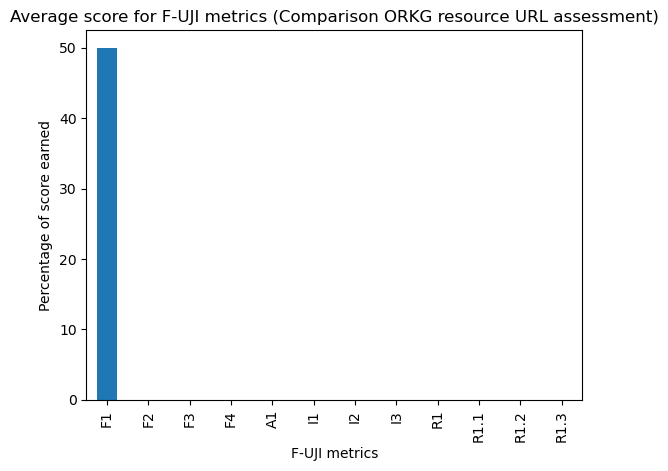

In [33]:
comp_url_df_submetrics["score_percent"].plot(kind="bar")
locs, labels = plt.xticks()
plt.xticks(locs, ["F1", "F2", "F3", "F4", "A1", "I1", "I2", "I3", "R1", "R1.1", "R1.2", "R1.3"])
plt.title("Average score for F-UJI metrics (Comparison ORKG resource URL assessment)")
plt.ylabel("Percentage of score earned")
plt.xlabel("F-UJI metrics")
plt.show()

## Comparison of comparisons

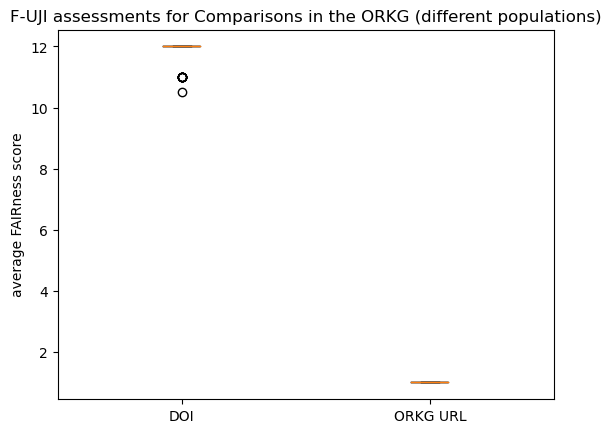

In [34]:
doi_df = comp_doi_df_FAIR
orkg_resource_url_df = comp_url_df_FAIR

assessement_data = [doi_df["score_earned"], orkg_resource_url_df["score_earned"]]
plt.boxplot(assessement_data)
plt.title("F-UJI assessments for Comparisons in the ORKG (different populations)")
locs, labels = plt.xticks()
plt.xticks(locs, ["DOI", "ORKG URL"])
plt.ylabel("average FAIRness score")
plt.show()

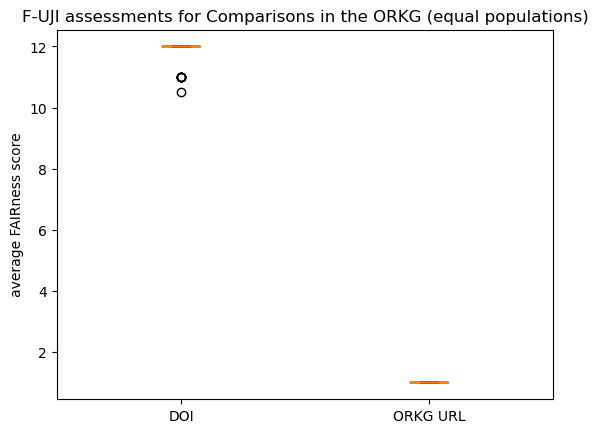

In [35]:
doi_orkg_df = pd.merge(doi_df, orkg_resource_url_df, on=["comparison", "doi"], suffixes=("_doi", "_orkg"))
assessement_data_merged = [doi_orkg_df["score_earned_doi"], doi_orkg_df["score_earned_orkg"]]
plt.boxplot(assessement_data_merged)
plt.title("F-UJI assessments for Comparisons in the ORKG (equal populations)")
locs, labels = plt.xticks()
plt.xticks(locs, ["DOI", "ORKG URL"])
plt.ylabel("average FAIRness score")
plt.show()

# Resources

In [67]:
def extend_resource_df(df):
    df_ext = pd.DataFrame()

    df_ext["resource"] = list(chain.from_iterable([[x]*17 for x in df["resources"]]))
    df_ext["type_rsrc"] = list(chain.from_iterable([[x]*17 for x in df["type_rsrc"]]))
    df_ext["type_other"] = list(chain.from_iterable([[x]*17 for x in df["type_other"]]))
    df_ext['metric'] = list(chain.from_iterable(list(x.keys()) for x in df['maturity']))
    df_ext['maturity'] = list(chain.from_iterable(x.values() for x in df['maturity']))
    df_ext['score_earned'] = list(chain.from_iterable(x.values() for x in df['score_earned']))
    df_ext['score_percent'] = list(chain.from_iterable(x.values() for x in df['score_percent']))
    df_ext['score_total'] = list(chain.from_iterable(x.values() for x in df['score_total']))
    df_ext['status_passed'] = list(chain.from_iterable(x.values() for x in df['status_passed']))
    df_ext['status_total'] = list(chain.from_iterable(x.values() for x in df['status_total']))

    return df_ext

## Resource assessment

In [76]:
%%script false --no-raise-error
resource_df = pd.read_csv("raw_data/resource_query_result_2023-04-05.csv")
resource_rsrc_df = resource_df[resource_df["type"].str.endswith("Resource")]
resource_others_df = resource_df[np.logical_not(resource_df["type"].str.endswith("Resource"))]
resource_df = pd.merge(resource_rsrc_df, resource_others_df, on="resources", how="outer", suffixes=("_rsrc", "_other"))
resource_df = resource_df[np.logical_not(resource_df["type_other"].str.endswith("Paper") | resource_df["type_other"].str.endswith("Comparison"))].reset_index(drop=True)
resource_df = resource_df.sample(n=3000, random_state=13)
resource_df = resource_df.reset_index(drop=True)
count = 0
resource_df["assessment_summary"] = resource_df["resources"].map(lambda x: get_assessment(x))
resource_df = resource_df[resource_df["assessment_summary"].isna() == False]
resource_df_split = split_summary(resource_df)
resource_df_assessed = extend_resource_df(resource_df_split)
resource_df_assessed.to_csv("assessed_data/resource_df_F-UJI_assessment.csv")
resource_df_assessed


Couldn't find program: 'false'


## Resource evaluation + visualizations

In [78]:
resource_df_assessed = pd.read_csv("assessed_data/resource_df_F-UJI_assessment.csv", index_col=0)
resource_df_assessed

,resource,type_rsrc,type_other,metric,maturity,score_earned,score_percent,score_total,status_passed,status_total
0,http://orkg.org/orkg/resource/R145348,http://orkg.org/orkg/class/Resource,http://orkg.org/orkg/class/Contribution,A,0.0,0.0,0.00,3.0,0,3
1,http://orkg.org/orkg/resource/R145348,http://orkg.org/orkg/class/Resource,http://orkg.org/orkg/class/Contribution,A1,0.0,0.0,0.00,3.0,0,3
2,http://orkg.org/orkg/resource/R145348,http://orkg.org/orkg/class/Resource,http://orkg.org/orkg/class/Contribution,F,1.0,1.0,14.29,7.0,1,5
3,http://orkg.org/orkg/resource/R145348,http://orkg.org/orkg/class/Resource,http://orkg.org/orkg/class/Contribution,F1,2.0,1.0,50.00,2.0,1,2
4,http://orkg.org/orkg/resource/R145348,http://orkg.org/orkg/class/Resource,http://orkg.org/orkg/class/Contribution,F2,0.0,0.0,0.00,2.0,0,1
...,...,...,...,...,...,...,...,...,...,...
50995,http://orkg.org/orkg/resource/PWC_CONTEXT_AWAR...,http://orkg.org/orkg/class/Resource,http://orkg.org/orkg/class/Model,R,0.0,0.0,0.00,10.0,0,5
50996,http://orkg.org/orkg/resource/PWC_CONTEXT_AWAR...,http://orkg.org/orkg/class/Resource,http://orkg.org/orkg/class/Model,R1,0.0,0.0,0.00,4.0,0,1
50997,http://orkg.org/orkg/resource/PWC_CONTEXT_AWAR...,http://orkg.org/orkg/class/Resource,http://orkg.org/orkg/class/Model,R1.1,0.0,0.0,0.00,2.0,0,1
50998,http://orkg.org/orkg/resource/PWC_CONTEXT_AWAR...,http://orkg.org/orkg/class/Resource,http://orkg.org/orkg/class/Model,R1.2,0.0,0.0,0.00,2.0,0,1


In [79]:
resource_df_FAIR = resource_df_assessed[resource_df_assessed["metric"] == "FAIR"].reset_index(drop=True)
resource_df_FAIR

,resource,type_rsrc,type_other,metric,maturity,score_earned,score_percent,score_total,status_passed,status_total
0,http://orkg.org/orkg/resource/R145348,http://orkg.org/orkg/class/Resource,http://orkg.org/orkg/class/Contribution,FAIR,1.0,1.0,4.17,24.0,1,16
1,http://orkg.org/orkg/resource/PWC_IMDB_REVIEWS...,http://orkg.org/orkg/class/Resource,http://orkg.org/orkg/class/BENCHMARK_DATASET,FAIR,1.0,1.0,4.17,24.0,1,16
2,http://orkg.org/orkg/resource/R66133,http://orkg.org/orkg/class/Resource,http://orkg.org/orkg/class/C0,FAIR,1.0,1.0,4.17,24.0,1,16
3,http://orkg.org/orkg/resource/R140362,http://orkg.org/orkg/class/Resource,NaN,FAIR,1.0,1.0,4.17,24.0,1,16
4,http://orkg.org/orkg/resource/R172616,http://orkg.org/orkg/class/Resource,http://orkg.org/orkg/class/C23006,FAIR,1.0,1.0,4.17,24.0,1,16
...,...,...,...,...,...,...,...,...,...,...
2995,http://orkg.org/orkg/resource/R161659,http://orkg.org/orkg/class/Resource,http://orkg.org/orkg/class/Author,FAIR,1.0,1.0,4.17,24.0,1,16
2996,http://orkg.org/orkg/resource/PWC_CBR_TS_MODEL,http://orkg.org/orkg/class/Resource,http://orkg.org/orkg/class/Model,FAIR,1.0,1.0,4.17,24.0,1,16
2997,http://orkg.org/orkg/resource/R147007,http://orkg.org/orkg/class/Resource,http://orkg.org/orkg/class/Venue,FAIR,1.0,1.0,4.17,24.0,1,16
2998,http://orkg.org/orkg/resource/R155405,http://orkg.org/orkg/class/Resource,http://orkg.org/orkg/class/Contribution,FAIR,1.0,1.0,4.17,24.0,1,16


In [80]:
resource_df_F_A_I_R = resource_df_assessed[(resource_df_assessed['metric'] == "F") | (resource_df_assessed['metric'] == "A") | (resource_df_assessed['metric'] == "I") | (resource_df_assessed['metric'] == "R")].reset_index(drop=True)

agg_funcs = {'maturity': 'mean', 'score_earned': 'mean', 'score_percent': 'mean', 'score_total': 'mean', 'status_passed': 'mean', 'status_total': 'mean'}
resource_df_F_A_I_R = resource_df_F_A_I_R.groupby("metric", as_index=False).agg(agg_funcs)

resource_df_F_A_I_R['metric'] = pd.Categorical(resource_df_F_A_I_R['metric'], ["F", "A", "I", "R"])
resource_df_F_A_I_R = resource_df_F_A_I_R.sort_values('metric').reset_index(drop=True)

resource_df_F_A_I_R

,metric,maturity,score_earned,score_percent,score_total,status_passed,status_total
0,F,1.0,1.0,14.29,7.0,1.0,5.0
1,A,0.0,0.0,0.00,3.0,0.0,3.0
2,I,0.0,0.0,0.00,4.0,0.0,3.0
3,R,0.0,0.0,0.00,10.0,0.0,5.0


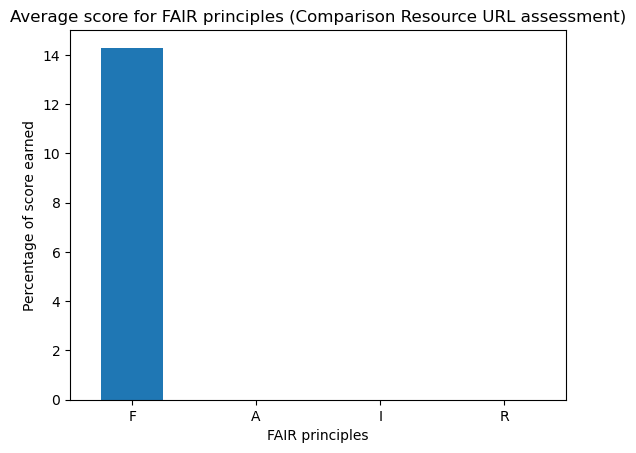

In [81]:
resource_df_F_A_I_R["score_percent"].plot(kind="bar")
locs, labels = plt.xticks()
plt.xticks(locs, ["F", "A", "I", "R"], rotation=0)
plt.title("Average score for FAIR principles (Comparison Resource URL assessment)")
plt.ylabel("Percentage of score earned")
plt.xlabel("FAIR principles")
plt.show()

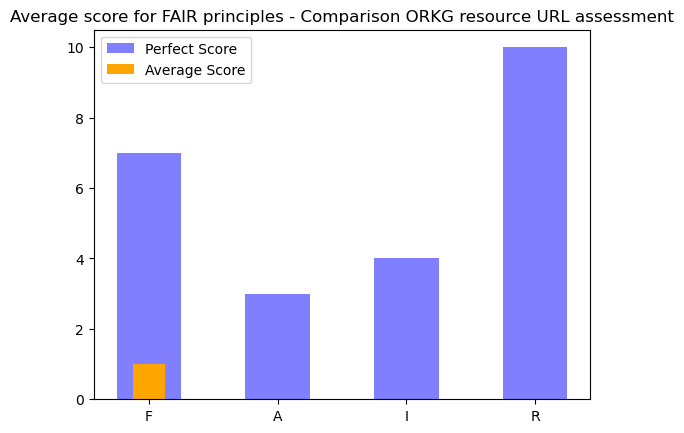

In [82]:
width = 0.5
perfect_scores = resource_df_F_A_I_R["score_total"]
actual_scores = resource_df_F_A_I_R['score_earned']
indices = np.arange(len(resource_df_F_A_I_R['metric']))
plt.bar(indices, perfect_scores, width=width, color='b', alpha=0.5, label='Perfect Score')
plt.bar([i for i in indices], actual_scores, width=0.5*width, color='orange', label='Average Score')
plt.xticks(indices, resource_df_F_A_I_R['metric'] )
plt.title("Average score for FAIR principles - Comparison ORKG resource URL assessment")
plt.legend()
plt.show()

In [83]:
resource_df_submetrics = resource_df_assessed[np.logical_not((resource_df_assessed['metric'] == "F") | (resource_df_assessed['metric'] == "A") | (resource_df_assessed['metric'] == "I") | (resource_df_assessed['metric'] == "R") | (resource_df_assessed['metric'] == "FAIR"))].reset_index(drop=True)

agg_funcs = {'maturity': 'mean', 'score_earned': 'mean', 'score_percent': 'mean', 'score_total': 'mean', 'status_passed': 'mean', 'status_total': 'mean'}
resource_df_submetrics = resource_df_submetrics.groupby("metric", as_index=False).agg(agg_funcs)

resource_df_submetrics['metric'] = pd.Categorical(resource_df_submetrics['metric'], ["F1", "F2", "F3", "F4", "A1", "I1", "I2", "I3", "R1", "R1.1", "R1.2", "R1.3"])
resource_df_submetrics = resource_df_submetrics.sort_values('metric').reset_index(drop=True)

resource_df_submetrics

,metric,maturity,score_earned,score_percent,score_total,status_passed,status_total
0,F1,2.0,1.0,50.0,2.0,1.0,2.0
1,F2,0.0,0.0,0.0,2.0,0.0,1.0
2,F3,0.0,0.0,0.0,1.0,0.0,1.0
3,F4,0.0,0.0,0.0,2.0,0.0,1.0
4,A1,0.0,0.0,0.0,3.0,0.0,3.0
5,I1,0.0,0.0,0.0,2.0,0.0,1.0
6,I2,0.0,0.0,0.0,1.0,0.0,1.0
7,I3,0.0,0.0,0.0,1.0,0.0,1.0
8,R1,0.0,0.0,0.0,4.0,0.0,1.0
9,R1.1,0.0,0.0,0.0,2.0,0.0,1.0


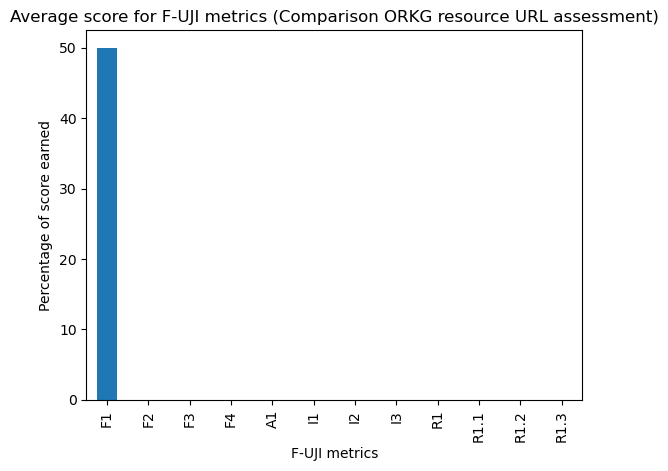

In [84]:
resource_df_submetrics["score_percent"].plot(kind="bar")
locs, labels = plt.xticks()
plt.xticks(locs, ["F1", "F2", "F3", "F4", "A1", "I1", "I2", "I3", "R1", "R1.1", "R1.2", "R1.3"])
plt.title("Average score for F-UJI metrics (Comparison ORKG resource URL assessment)")
plt.ylabel("Percentage of score earned")
plt.xlabel("F-UJI metrics")
plt.show()